In [ ]:
#import libraries
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numba
import cv2
from sklearn.preprocessing import StandardScaler

In [ ]:
google_save=True
if google_save:
  from google.colab import drive
  drive.mount('/content/drive/')

Mounted at /content/drive/


# input data

In [ ]:
#constants
#заряд электрона Кл
e=1.60218*10**(-19)
#температура до прохождения пучка в кельвинах  
Tcool = 300
#Стала Стефана — Больцмана Вт/(мм^2·К^4),
sig=5.6704*10**(-8)*10**(-6) 
#dt = 10**(-9)

In [ ]:

#Расстояние до стенок
r_w=57/2
I= 1*10**(-6) #амперы пучка


In [ ]:
#данные пленки
# plate size, mm
w = h = 57
# intervals in x-, y- directions, mm
dx = dy = 0.1
dx2 = dy2 = (dx*dy)
#центр
cx,cy=w/2,h/2
Tcool  = 300 #Кельвинов
nx, ny = int(w/dx), int(h/dy)#размер сетки 
u0 = Tcool * np.ones((nx, ny))#начальная сетка
Kapton=False
Aluminium=False
Titanium=True
if Kapton:
  h_pl=125*10**(-3) #высота пленки мм
  #http://www.matweb.com/search/datasheet_print.aspx?matguid=338573ad1bdf4586aa17fab95f3a57d7
  c=1090 #Specific Heat Capacity 	J/(kg*K)
  #https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FRelevant-material-properties-for-Kapton-HN-and-H4-PZT_tbl1_251498137&psig=AOvVaw0ZQK0lDwOnkJuxRiIKdfia&ust=1636615266907000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJCKnJChjfQCFQAAAAAdAAAAABAS
  #https://www.dupont.com/products/kapton-mt-plus.html
  #https://www.dupont.com/products/kapton-fn.html
  #https://www.dupont.com/products/kapton-hn.html
  #kapton density kg/mm^3 
  rho= 1420*10**(-9) 
  #Коэффициент теплоотдачи α 
  alp=80*10**(-6)
  # Thermal diffusivity of kapton, mm2.s-1
  #https://www.dupont.com/products/kapton-fpc.html 
  D = 20.
  # https://www.researchgate.net/publication/305954072_Analysis_of_Thermal_Radiation_Properties_of_Polyimide_and_Polymeric_Materials_Based_on_ATR-IR_spectroscopy
  a=0.74#коєфиицент черноты
  #Thot2=(I*dE/(e*2*a*sig*S)+Tcool**4)**(1/4)
  dE=37.363*10**(3)*e #потери одного электрона при прохождении сквозь каптон J
if Aluminium:
  h_pl=50*10**(-3) #высота пленки мм
  c=887	 #Specific Heat Capacity 	J/(kg*K)
  #Aluminium density kg/mm^3 
  rho= 2720*10**(-9) 
  #Коэффициент теплоотдачи α 
  alp=80*10**(-6)#just something
  # Thermal diffusivity of aluminium, mm2.s-1
  D = 97.
  a=0.1#коєфиицент черноты
  #Thot2=(I*dE/(e*2*a*sig*S)+Tcool**4)**(1/4)
  dE=28.809*10**(3)*e #потери одного электрона при прохождении сквозь Aluminium J

if Titanium:
  h_pl=50*10**(-3) #высота пленки мм
  c=523 #Specific Heat Capacity 	J/(kg*K)
  #Titanium density kg/mm^3 
  rho= 4500.*10**(-9) 
  #Коэффициент теплоотдачи α 
  alp=80*10**(-6)
  # Thermal diffusivity of titanium, mm2.s-1
  D = 9.
  a=0.19#коєфиицент черноты
  #Thot2=(I*dE/(e*2*a*sig*S)+Tcool**4)**(1/4)
  dE=51.2339*10**(3)*e #потери одного электрона при прохождении сквозь Titanium J


Вычисления Гаусового распределения тока

<Axes: >

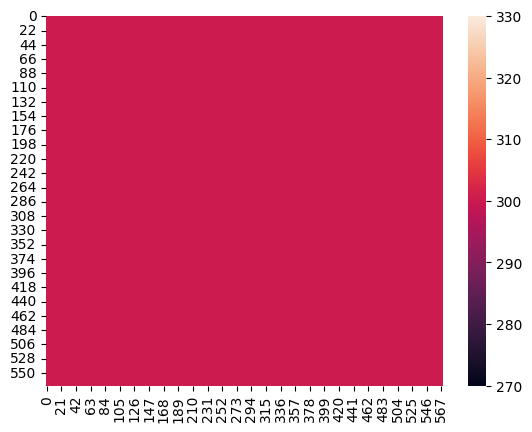

In [ ]:
sns.heatmap(cv2.blur(cv2.blur(u0,(20,20),1),(20,20),1))

(96, 96)


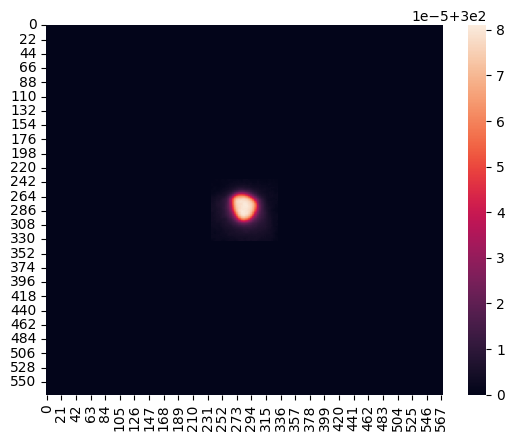

In [ ]:
Practical=True
Analitic=False
if Analitic:
  gau=True
  #beam data
  #если считать, что пучок будет иметь форму круга то
  #10=pi*x^2
  r=1.78412#radius in mm
  #квадрат радиуса mm^2
  r2 = r**2
  #area
  S=3.1415*r2 
  def gkern(kernlen=3, nsig=3,gau=False,parabolic=False):
      x = np.linspace(-nsig, nsig, kernlen+1)
      if gau:
        kern1d = np.diff(st.norm.cdf(x))
      if parabolic:
        kern1d =  np.diff(st.rdist.cdf(x,5))
      kern2d = np.outer(kern1d, kern1d)
      return kern2d/kern2d.sum()
  I_dist=gkern(kernlen=2*int(r/dx), nsig=1,parabolic=True)*I
#  sns.heatmap(I_dist)
  @numba.njit()

  def add_T_2_d(u_temp,I,dE):
    #замена квадрата в центре
    #+1 с начала 
    u_temp[int(u_temp.shape[0]/2-r/dx+1):int(u_temp.shape[0]/2+r/dx),int(u_temp.shape[1]/2-r/dy+1):int(u_temp.shape[1]/2+r/dy)]\
    =(I*dE/(e*2*a*sig*dx*dy)\
      +(u_temp[int(u_temp.shape[0]/2-r/dx+1):int(u_temp.shape[0]/2+r/dx),int(u_temp.shape[1]/2-r/dy+1):int(u_temp.shape[1]/2+r/dy)])**4)\
      **(1/4)
    return u_temp
    
  @numba.njit()
  def add_T_2(u_temp,I,dE):
      for i in range(nx):
        for j in range(ny):
            p2 = (i*dx-cx)**2 + (j*dy-cy)**2
            if p2 < (r*r):
              u_temp[i,j]=(I*dE/(e*2*a*sig*dx*dy)+(u_temp[i,j])**4)**(1/4)
      return u_temp
  sns.heatmap(add_T_2_d(u0,I_dist,dE))
if Practical:
  dt = 10**(-5)#каждый временной шаг происходит 100 μ
  #радиус пучка вериткальній приблизительно 6 мм -[21:108,26:113] on img 
  r=3
  I_dist = cv2.imread(r"/content/drive/MyDrive/Heat_transfer/masks/60.jpg",0)
  I_dist=cv2.blur(I_dist,(7,7),)
  I_dist=I_dist/I_dist.sum()*I
  #subtract the fadedness of window
  I_dist-=I_dist.min()
  #resize to fit in square
  #radius of full picture
  #142/87*r - 142 full size of picture in pixels,87 full size of beam in pixels,3beam size in mm
  r=142/87*r
  I_dist=cv2.resize(I_dist, dsize=(round(2*r/dx)-2,round(2*r/dx)-2), interpolation=cv2.INTER_LINEAR
)
  print(I_dist.shape)
  @numba.njit()
  def add_T_2_d(u_temp,I_dist,dE):
    #замена квадрата в центре
    #+1 с начала 
    u_temp[int(u_temp.shape[0]/2-r/dx+1):int(u_temp.shape[0]/2+r/dx),int(u_temp.shape[1]/2-r/dy+1):int(u_temp.shape[1]/2+r/dy)]\
    =(I_dist*dE*dt/(e*c*(rho*dx*dy*h_pl))+(u_temp[int(u_temp.shape[0]/2-r/dx+1):int(u_temp.shape[0]/2+r/dx),int(u_temp.shape[1]/2-r/dy+1):int(u_temp.shape[1]/2+r/dy)]))
    
    return u_temp
  
  sns.heatmap(add_T_2_d(u0,I_dist,dE))

In [ ]:
(I*dE*dt/(e*c*(rho*dx*dy*h_pl)))

0.43538474612279576

In [ ]:
#smothing image for decreasing error
for i in range(12):
  u0=cv2.blur(cv2.blur(u0,(6,6),1),(6,6),1)

87/142=3/x<br>
pix/pix=mm/mm
<br>dQ/dt=cm𝜟T/dt=IdE/e               
*𝜟T*=(IdE/e)*dt/cm

<Axes: >

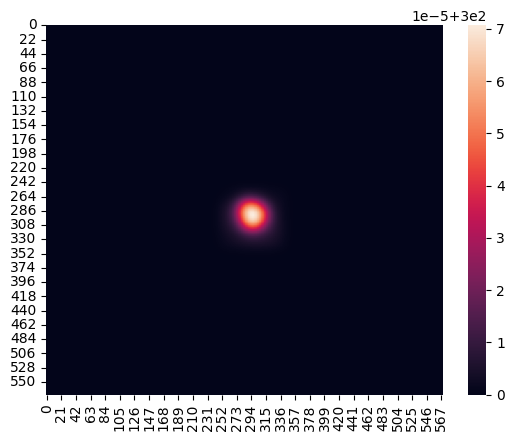

In [ ]:
sns.heatmap(u0)

In [ ]:
u0.shape[0]-19

551

In [ ]:
u0[10:-11,10:-11].shape

(549, 549)

In [ ]:
import numpy as np
from scipy import interpolate
x = np.linspace(-1, 1, u0.shape[0]-21)
y = np.linspace(-1, 1, u0.shape[0]-21)

func = interpolate.interp2d(x, y, u0[10:-11,10:-11], kind='linear')


<ipython-input-13-521679007963>:6: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  func = interpolate.interp2d(x, y, u0[10:-11,10:-11], kind='linear')


<ipython-input-15-99270a69a6fe>:1: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  sns.heatmap(func(x,y))


<Axes: >

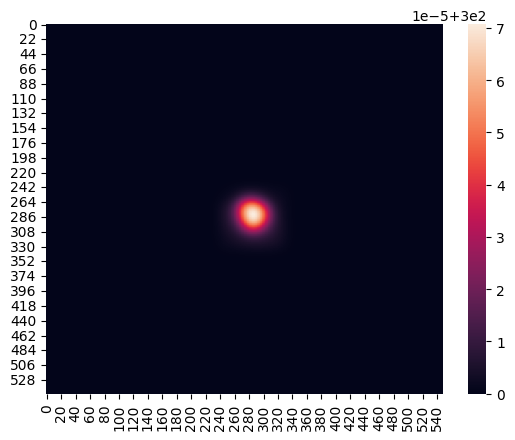

In [ ]:
sns.heatmap(func(x,y))

In [ ]:
import numpy as np
from scipy.integrate import dblquad
from scipy.special import jn
from scipy.special import jn_zeros
number_of_bessel=100
number_of_sine=10
def f(r, theta):
    # Define the 2D function to be approximated
    return func(r*np.sin(theta),r*np.cos(theta))
def integrand(r, theta, n, m, f):
    return f(r, theta) * jn(n, k[n][m] * r) * np.sin(m * theta)


def calc_coeffs(f, k):
    a = np.zeros((len(k), len(k[0])))
    for n in range(len(k)):
        for m in range(len(k[0])):
            result, _ = dblquad(integrand, 0, 1, 0, 2 * np.pi, args=(n, m, f))
            a[n][m] = result / (2 * np.pi)
    return a


k = np.zeros((number_of_bessel, number_of_sine))
# Calculate the roots of the Bessel functions

for n in range(number_of_bessel):
    for m in range(number_of_sine):
        k[n][m] = jn_zeros(n, m + 1)[m]

#a = calc_coeffs(f, k)
def approx_func(r,theta):
    value=0
    for n in range(number_of_bessel):
      for m in range(number_of_sine):
        value+=a[n][m]*jn(n, k[n][m] * r) * np.sin(m * theta)
    return value
    

In [ ]:
one_mod=lambda r,theta: a[n][m]*jn(n, k[n][m] * r) * np.sin(m * theta)

<ipython-input-16-237afcd9caf8>:9: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  return func(r*np.sin(theta),r*np.cos(theta))


<Axes: >

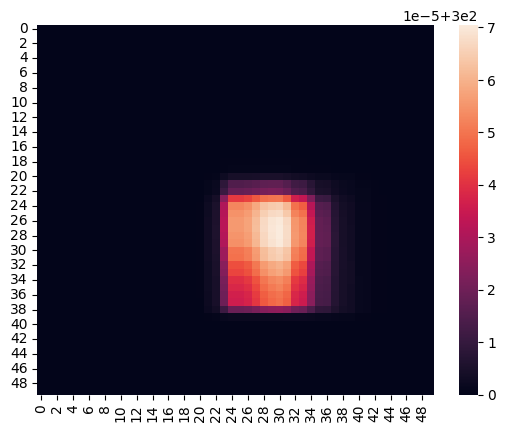

In [ ]:
R,Tet=np.meshgrid(np.linspace(0,1,),np.linspace(0,2*np.pi,20))
sns.heatmap(f(np.linspace(0,1,),np.linspace(0,2*np.pi,50)))

<Axes: >

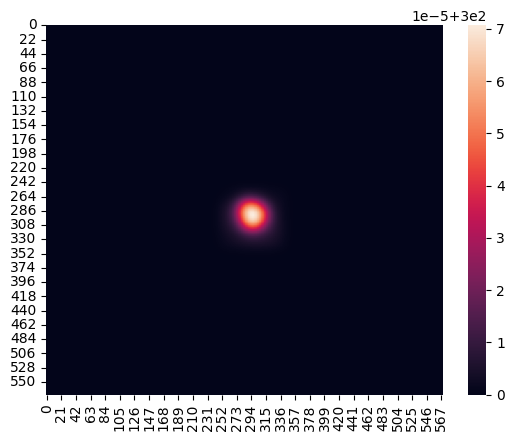

In [ ]:
sns.heatmap(u0)

<Axes: >

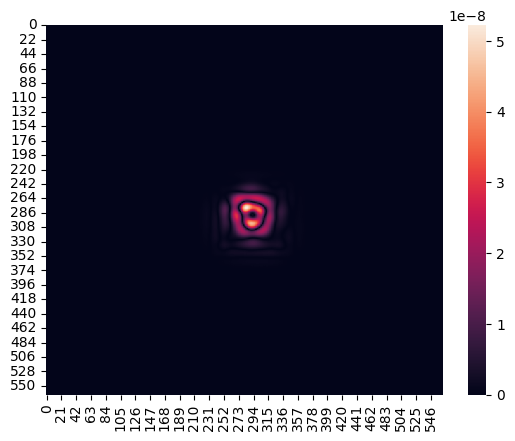

In [ ]:
sns.heatmap(dx**2/12*(abs((-1/6*u0[:-6,3:-3]+2*u0[1:-5,3:-3]-13/2*u0[2:-4,3:-3]+28/3*u0[3:-3,3:-3]-13/2*u0[4:-2,3:-3]+2*u0[5:-1,3:-3]-1/6*u0[6:,3:-3,])/dx**4\
                       +(-1/6*u0[3:-3,:-6]+2*u0[3:-3,1:-5]-13/2*u0[3:-3,2:-4]+28/3*u0[3:-3,3:-3]-13/2*u0[3:-3,4:-2]+2*u0[3:-3,5:-1]-1/6*u0[3:-3,6:,])/dx**4)))

<Axes: >

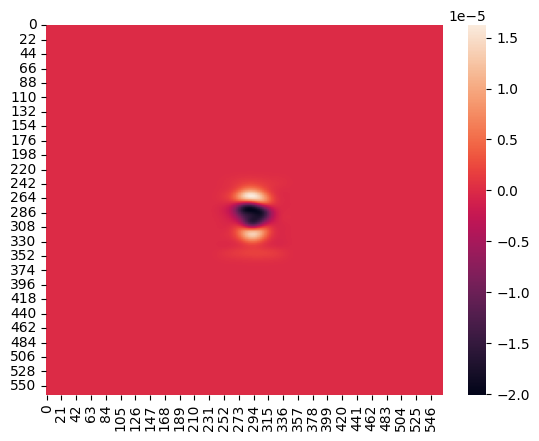

In [ ]:
sns.heatmap((1/90*u0[:-6, 3:-3] -3/20* u0[1:-5, 3:-3]+3/2* u0[2:-4, 3:-3]-49/18*u0[3:-3, 3:-3] +3/2*u0[4:-2,3:-3]-3/20* u0[5:-1, 3:-3]+1/90*u0[6:, 3:-3] )/dx2+ (1/90*u0[3:-3,:-6, ] -3/20* u0[3:-3,1:-5]+3/2* u0[3:-3,2:-4]-49/18*u0[3:-3, 3:-3] +3/2*u0[3:-3,4:-2]-3/20* u0[3:-3,5:-1]+1/90*u0[3:-3,6:]))

# вспомогательные функции

In [ ]:
#https://en.wikipedia.org/wiki/Finite_difference_coefficient
#second central 2 acc time deriveative
#fourth central 4 acc time deriveative
def error(time,dt,dx,i):
  u0=time[...,i]
  return (1/12*dx**2*abs((-1/6*u0[:-6,3:-3]+2*u0[1:-5,3:-3]-13/2*u0[2:-4,3:-3]+28/3*u0[3:-3,3:-3]-13/2*u0[4:-2,3:-3]+2*u0[5:-1,3:-3]-1/6*u0[6:,3:-3,])/dx**4\
                       +(-1/6*u0[3:-3,:-6]+2*u0[3:-3,1:-5]-13/2*u0[3:-3,2:-4]+28/3*u0[3:-3,3:-3]-13/2*u0[3:-3,4:-2]+2*u0[3:-3,5:-1]-1/6*u0[3:-3,6:,])/dx**4))\
                       +dt/2*abs(time[3:-3,3:-3,i-1]-2*time[3:-3,3:-3,i]+time[3:-3,3:-3,i+1])/(dt**2)

def error(time,dt,dx,i):
  u0=time[...,i]
  return (1/12*dx**2*abs((1*u0[1:-5,3:-3]-4*u0[2:-4,3:-3]+6*u0[3:-3,3:-3]-4*u0[4:-2,3:-3]+1*u0[5:-1,3:-3])/dx**4\
                       +(1*u0[3:-3,1:-5]-4*u0[3:-3,2:-4]+6*u0[3:-3,3:-3]-4*u0[3:-3,4:-2]+1*u0[3:-3,5:-1])/dx**4))\
                       +dt/2*abs(time[3:-3,3:-3,i-1]-2*time[3:-3,3:-3,i]+time[3:-3,3:-3,i+1])/(dt**2)


In [ ]:
#mas of one domen
dm=dx*dy*h_pl*rho
#u0=add_T_2(u0,I_dist,dE)


In [ ]:
@numba.njit()
def correction(u0,r):
  for i in range(nx):
      for j in range(ny):
          p2 = (i*dx-cx)**2 + (j*dy-cy)**2
          if p2 > (r*r):
              u0[i,j] = Tcool
  return u0


In [ ]:
@numba.njit
def radiation(u0,dt):
    du=(u0**4-(Tcool*np.ones((int(u0.shape[0]),int(u0.shape[0]))))**4)*sig*a*dt/(c*h_pl*rho) #https://www.engineeringtoolbox.com/radiation-heat-transfer-d_431.html
    return du

In [ ]:
@numba.njit()
def convection(u0,dt):
    du=alp*(u0-Tcool*np.ones((int(u0.shape[0]),int(u0.shape[0]))))*dt/(c*h_pl*rho) #https://www.isuct.ru/dept/chemkiber/piaht/metodwork/newmet/1.htm#:~:text=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82%20%D1%82%D0%B5%D0%BF%D0%BB%D0%BE%D0%BE%D1%82%D0%B4%D0%B0%D1%87%D0%B8%20%CE%B1%20%E2%80%93%20%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D1%83%D0%B5%D1%82%20%D0%B8%D0%BD%D1%82%D0%B5%D0%BD%D1%81%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D1%8C,1%20%D0%B3%D1%80%D0%B0%D0%B4%D1%83%D1%81%20(%D0%9A)%2C%20.
    return du

In [ ]:


@numba.njit()
def conduction(u0, u,dt):
    # Propagate with forward-difference in time, central-difference in space
   # u0[1:-1, 1:-1]-=radiation(u0[1:-1, 1:-1],dt) #отход тепла из-за излучения
   # u0[1:-1, 1:-1]-=convection(u0[1:-1, 1:-1],dt) #отход тепла из-за конвекции 
    u[3:-3, 3:-3] = u0[3:-3, 3:-3] + D * dt * (#second order central deriveative 6 th accuracy
          (1/90*u0[:-6, 3:-3] -3/20* u0[1:-5, 3:-3]+3/2* u0[2:-4, 3:-3]-49/18*u0[3:-3, 3:-3] +3/2*u0[4:-2,3:-3]-3/20* u0[5:-1, 3:-3]+1/90*u0[6:, 3:-3] )/dx2
          + (1/90*u0[3:-3,:-6, ] -3/20* u0[3:-3,1:-5]+3/2* u0[3:-3,2:-4]-49/18*u0[3:-3, 3:-3] +3/2*u0[3:-3,4:-2]-3/20* u0[3:-3,5:-1]+1/90*u0[3:-3,6:] )/dy2 ) #переход тепла в пленке 
    u=correction(u,r_w) #условие, что температура стенок неизменна 
    u0 = u.copy()
    return u0, u

In [ ]:
@numba.njit()
def conduction(u0, u,dt):
    # Propagate with forward-difference in time, central-difference in space
    u0[1:-1, 1:-1]-=radiation(u0[1:-1, 1:-1],dt) #отход тепла из-за излучения
   # u0[1:-1, 1:-1]-=convection(u0[1:-1, 1:-1],dt) #отход тепла из-за конвекции 
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 ) #переход тепла в пленке 
  #  u=correction(u,r_w) #условие, что температура стенок неизменна 
    u0 = u.copy()
    return u0, u

<Axes: >

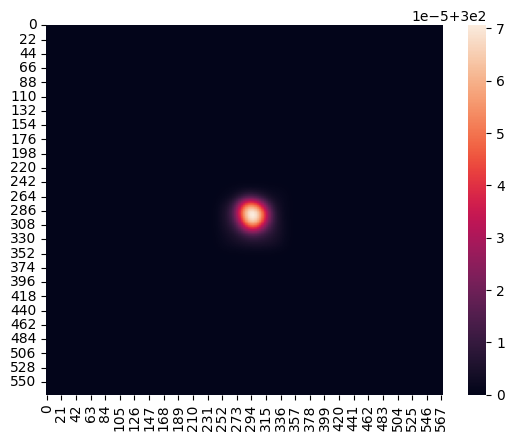

In [ ]:
dt = 10**(-4)#каждый временной шаг происходит 100 μ
#u0=add_T_2(u0, I_dist,dE)

sns.heatmap(conduction(u0,u0,dt)[0])


<Axes: >

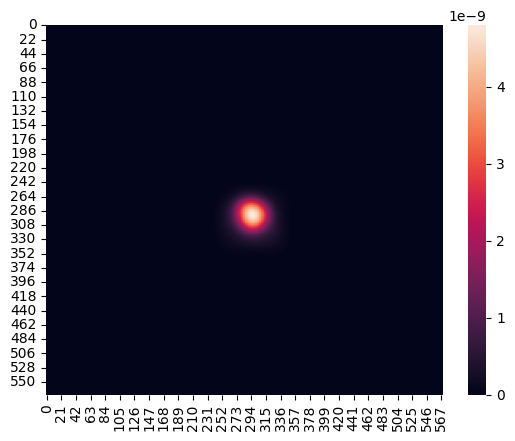

In [ ]:
sns.heatmap(convection(u0,dt))


In [ ]:
#u0=add_T_2(u0, I_dist,dE)
#u0-=radiation(u0,dt)
#u0-=convection(u0,dt)
#u0[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
#          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
 #         + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )
#sns.heatmap(u0)
#step=1
#plt.title(f"максимальная температура-{u0.max()} спустя {step*dt}")


# main function

In [ ]:
max_T=np.array([[]])

In [ ]:
#минимальный шаг- время импульса

In [ ]:
#u0=kapton_new[:,:,-1]
u0 = Tcool * np.ones((nx, ny))#начальная сетка


In [ ]:
###@title Heat transfer picture by picture

dt = 2*10**(-5)#каждый временной шаг происходит 100 μ
dt_energy=dt # каждые н секунд добавляется энергия от пучка 

u = u0.copy()
#u0=add_T_2(u0,I_dist,dE)
save_arr=np.expand_dims(u0,2)
#time of modulation
seconds=dt*10**5
# Number of timesteps
nsteps = int(seconds/dt)
#fig steps
fig_list=np.arange(0, nsteps, nsteps/100,dtype = int)
if Titanium:
  name_exp=f"Zadanie_1/Practical{round(I*10**6)}/titanium"
elif Kapton:
  name_exp=f"Zadanie_1/Practical{round(I*10**6)}/kapton"
elif Aluminium:
  name_exp=f"Zadanie_1/Practical{round(I*10**6)}/aluminium"

df=pd.DataFrame(columns=["Max_T","Min_T","N_Exp"])
from tqdm import tqdm

for step in tqdm(range(0,nsteps)):
    u0=add_T_2_d(u0,I_dist,dE)
    u0, u = conduction(u0, u,dt)
  #  print(f"Min and max Tempretures among all temperatures at {round(dt*step,8)} s ater start ")
  #  print(f"min value - {u0.min()},max value - {u0.max()}")
    if int(step) in fig_list:
      max_T=np.append(max_T,u0.max())
      print(step)
#making picture
      ax=plt.figure(figsize=(12,10))
      sns.heatmap(u0,cmap="jet", yticklabels=False,xticklabels=False)
      #print([int(nx/2-fig_s):int(nx/2+fig_s),int(ny/2-fig_s):int(ny/2+fig_s)])
      plt.title(f"max-{round(u0.max(),4)},min-{round(u0.min(),4)}, after seconds {round(step*dt,14)}")
#saving progress
      plt.savefig(f"/content/drive/MyDrive/Heat_transfer/{name_exp}/{step}.png")
      plt.close()
      df.loc[len(df)] = [u0.max(),u0.min(),f"name_exp  {step}"]
      save_arr=np.append(save_arr,np.expand_dims(u0,2),2)
      np.save(f"/content/drive/MyDrive/Heat_transfer/{name_exp}",save_arr)



  0%|          | 0/99999 [00:00<?, ?it/s]

0


  1%|          | 996/99999 [00:19<15:35, 105.84it/s]

999


  2%|▏         | 1997/99999 [00:31<15:33, 104.99it/s]

1998


  3%|▎         | 2995/99999 [00:45<15:14, 106.04it/s]

2997


  4%|▍         | 3986/99999 [00:57<14:49, 107.89it/s]

3996


  5%|▍         | 4988/99999 [01:09<22:46, 69.54it/s]

4995


  6%|▌         | 5993/99999 [01:20<14:01, 111.66it/s]

5994


  7%|▋         | 6991/99999 [01:32<14:05, 109.97it/s]

6993


  8%|▊         | 7987/99999 [01:44<14:07, 108.60it/s]

7992


  9%|▉         | 8985/99999 [01:56<14:26, 105.01it/s]

8991


 10%|▉         | 9979/99999 [02:08<15:16, 98.21it/s]

9990


 11%|█         | 10989/99999 [02:19<21:56, 67.63it/s]

10989


 12%|█▏        | 11983/99999 [02:31<15:12, 96.43it/s] 

11988


 13%|█▎        | 12978/99999 [02:43<12:59, 111.63it/s]

12987


 14%|█▍        | 13981/99999 [02:55<12:55, 110.89it/s]

13986


 15%|█▍        | 14975/99999 [03:07<12:56, 109.50it/s]

14985


 16%|█▌        | 15982/99999 [03:19<20:54, 66.99it/s]

15984


 17%|█▋        | 16975/99999 [03:29<12:41, 109.08it/s]

16983


 18%|█▊        | 17981/99999 [03:41<12:49, 106.58it/s]

17982


 19%|█▉        | 18972/99999 [03:54<12:16, 109.96it/s]

18981


 20%|█▉        | 19974/99999 [04:06<12:16, 108.65it/s]

19980


 21%|██        | 20977/99999 [04:18<12:57, 101.65it/s]

20979


 22%|██▏       | 21973/99999 [04:30<18:47, 69.19it/s]

21978


 23%|██▎       | 22972/99999 [04:41<12:30, 102.61it/s]

22977


 24%|██▍       | 23971/99999 [04:53<11:39, 108.66it/s]

23976


 25%|██▍       | 24975/99999 [05:06<11:12, 111.53it/s]

24975


 26%|██▌       | 25970/99999 [05:18<11:20, 108.85it/s]

25974


 27%|██▋       | 26970/99999 [05:30<18:00, 67.56it/s]

26973


 28%|██▊       | 27971/99999 [05:41<17:19, 69.27it/s]

27972


 29%|██▉       | 28966/99999 [05:53<13:24, 88.32it/s]

28971


 30%|██▉       | 29967/99999 [06:05<11:11, 104.28it/s]

29970


 31%|███       | 30965/99999 [06:18<10:24, 110.59it/s]

30969


 32%|███▏      | 31960/99999 [06:30<10:26, 108.59it/s]

31968


 33%|███▎      | 32967/99999 [06:42<16:14, 68.75it/s]

32967


 34%|███▍      | 33964/99999 [06:53<15:49, 69.52it/s]

33966


 35%|███▍      | 34964/99999 [07:05<12:11, 88.96it/s]

34965


 36%|███▌      | 35964/99999 [07:18<09:33, 111.72it/s]

35964


 37%|███▋      | 36954/99999 [07:30<09:28, 110.90it/s]

36963


 38%|███▊      | 37959/99999 [07:43<09:25, 109.73it/s]

37962


 39%|███▉      | 38960/99999 [07:57<20:12, 50.36it/s]

38961


 40%|███▉      | 39954/99999 [08:09<15:09, 65.99it/s]

39960


 41%|████      | 40955/99999 [08:21<14:14, 69.06it/s]

40959


 42%|████▏     | 41957/99999 [08:34<08:36, 112.32it/s]

41958


 43%|████▎     | 42952/99999 [08:47<08:28, 112.20it/s]

42957


 44%|████▍     | 43950/99999 [08:59<08:18, 112.52it/s]

43956


 45%|████▍     | 44954/99999 [09:12<08:51, 103.49it/s]

44955


 46%|████▌     | 45952/99999 [09:25<13:03, 68.98it/s]

45954


 47%|████▋     | 46952/99999 [09:36<12:26, 71.07it/s]

46953


 48%|████▊     | 47945/99999 [09:49<12:15, 70.74it/s]

47952


 49%|████▉     | 48948/99999 [10:02<07:56, 107.05it/s]

48951


 50%|████▉     | 49943/99999 [10:15<07:49, 106.70it/s]

49950


 51%|█████     | 50947/99999 [10:28<07:41, 106.34it/s]

50949


 52%|█████▏    | 51943/99999 [10:41<07:38, 104.90it/s]

51948


 53%|█████▎    | 52938/99999 [10:54<07:56, 98.79it/s]

52947


 54%|█████▍    | 53944/99999 [11:06<12:02, 63.75it/s]

53946


 55%|█████▍    | 54934/99999 [11:17<06:48, 110.33it/s]

54945


 56%|█████▌    | 55944/99999 [11:30<09:14, 79.38it/s]

55944


 57%|█████▋    | 56936/99999 [11:43<06:25, 111.83it/s]

56943


 58%|█████▊    | 57933/99999 [11:56<06:27, 108.45it/s]

57942


 59%|█████▉    | 58930/99999 [12:09<06:18, 108.55it/s]

58941


 60%|█████▉    | 59930/99999 [12:22<06:11, 107.93it/s]

59940


 61%|██████    | 60936/99999 [12:35<09:57, 65.34it/s]

60939


 62%|██████▏   | 61937/99999 [12:47<09:30, 66.68it/s]

61938


 63%|██████▎   | 62931/99999 [12:59<05:39, 109.06it/s]

62937


 64%|██████▍   | 63926/99999 [13:12<06:01, 99.80it/s]

63936


 65%|██████▍   | 64931/99999 [13:25<05:19, 109.88it/s]

64935


 66%|██████▌   | 65932/99999 [13:38<05:02, 112.43it/s]

65934


 67%|██████▋   | 66925/99999 [13:51<05:19, 103.48it/s]

66933


 68%|██████▊   | 67930/99999 [14:05<05:05, 105.11it/s]

67932


 69%|██████▉   | 68928/99999 [14:18<04:56, 104.79it/s]

68931


 70%|██████▉   | 69928/99999 [14:31<07:30, 66.79it/s]

69930


 71%|███████   | 70928/99999 [14:44<07:19, 66.08it/s]

70929


 72%|███████▏  | 71928/99999 [14:56<06:03, 77.17it/s]

71928


 73%|███████▎  | 72922/99999 [15:09<05:37, 80.17it/s]

72927


 74%|███████▍  | 73919/99999 [15:23<04:00, 108.35it/s]

73926


 75%|███████▍  | 74914/99999 [15:36<03:47, 110.33it/s]

74925


 76%|███████▌  | 75922/99999 [15:50<03:44, 107.33it/s]

75924


 77%|███████▋  | 76920/99999 [16:03<03:30, 109.57it/s]

76923


 78%|███████▊  | 77920/99999 [16:17<03:30, 105.07it/s]

77922


 79%|███████▉  | 78916/99999 [16:49<06:18, 55.68it/s]

78921


 80%|███████▉  | 79919/99999 [17:18<03:13, 103.56it/s]

79920


 81%|████████  | 80918/99999 [17:32<03:01, 104.95it/s]

80919


 82%|████████▏ | 81916/99999 [17:45<04:39, 64.63it/s]

81918


 83%|████████▎ | 82913/99999 [17:58<04:32, 62.66it/s]

82917


 84%|████████▍ | 83911/99999 [18:14<04:11, 63.86it/s]

83916


 85%|████████▍ | 84913/99999 [18:28<05:35, 45.01it/s]

84915


 86%|████████▌ | 85903/99999 [18:45<02:20, 100.09it/s]

85914


 87%|████████▋ | 86912/99999 [18:59<03:17, 66.36it/s]

86913


 88%|████████▊ | 87907/99999 [19:12<03:03, 66.01it/s]

87912


 89%|████████▉ | 88910/99999 [19:25<03:20, 55.19it/s]

88911


 90%|████████▉ | 89906/99999 [19:38<02:06, 80.02it/s]

89910


 91%|█████████ | 90907/99999 [19:52<01:46, 85.67it/s]

90909


 92%|█████████▏| 91905/99999 [20:06<01:14, 108.05it/s]

91908


 93%|█████████▎| 92903/99999 [20:20<01:04, 110.64it/s]

92907


 94%|█████████▍| 93904/99999 [20:34<00:57, 105.20it/s]

93906


 95%|█████████▍| 94901/99999 [20:48<00:47, 107.46it/s]

94905


 96%|█████████▌| 95897/99999 [21:02<00:37, 109.44it/s]

95904


 97%|█████████▋| 96894/99999 [21:16<00:29, 106.89it/s]

96903


 98%|█████████▊| 97900/99999 [21:30<00:19, 107.64it/s]

97902


 99%|█████████▉| 98896/99999 [21:43<00:10, 106.36it/s]

98901


100%|██████████| 99999/99999 [21:58<00:00, 75.84it/s] 


# PLOT

In [ ]:
kapton=np.load(f"/content/drive/MyDrive/Heat_transfer/Zadanie_1/Practical1/kapton.npy")
aluminium=np.load(f"/content/drive/MyDrive/Heat_transfer/Zadanie_1/Practical1/aluminium.npy")
titanium=np.load(f"/content/drive/MyDrive/Heat_transfer/Zadanie_1/Practical1/titanium.npy")

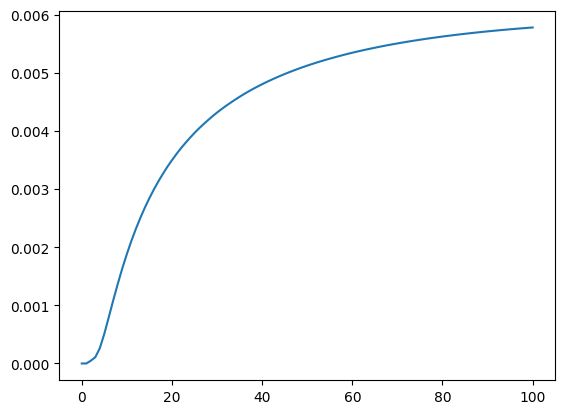

In [ ]:
plt.plot((kapton-titanium).max(axis=(0,1)))

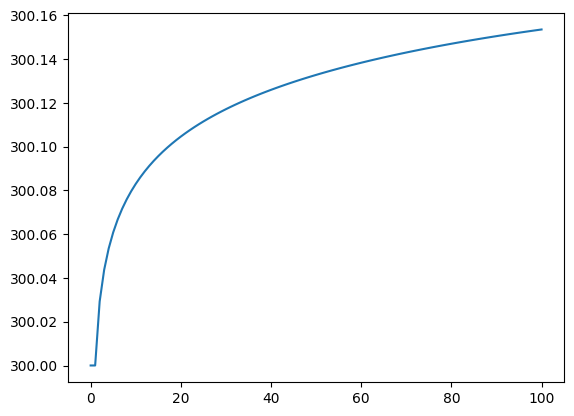

In [ ]:
plt.plot(aluminium.max(axis=(0,1)))

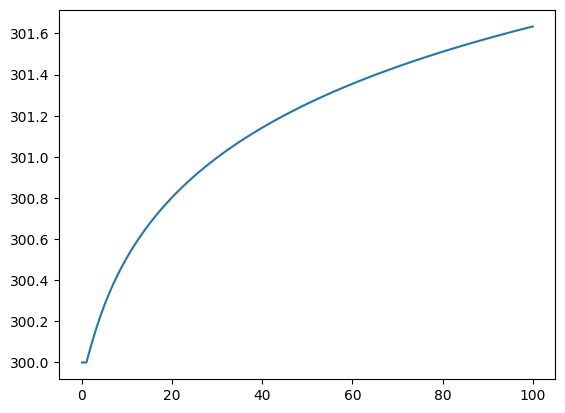

In [ ]:
plt.plot(titanium.max(axis=(0,1)))

Text(0.5, 0, 'Time [ms]')

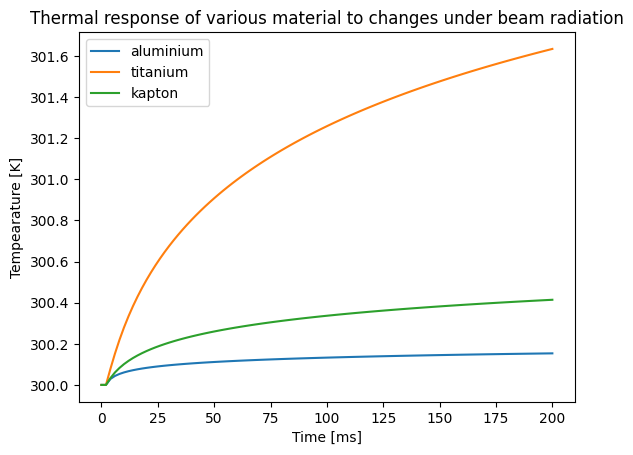

In [ ]:
plt.plot(np.arange(0,202,2),aluminium.max(axis=(0,1)),label="aluminium")
plt.plot(np.arange(0,202,2),titanium.max(axis=(0,1)),label="titanium")
plt.plot(np.arange(0,202,2),kapton.max(axis=(0,1)),label="kapton")
plt.legend()
plt.title("Thermal response of various material to changes under beam radiation")
plt.ylabel("Tempearature [K]")
plt.xlabel("Time [ms]")

In [ ]:
import numpy as np

# Specify the number of rows in the array
num_rows = kapton[:,:,-1].shape[0]

# Create an array of indices
indices = np.arange(num_rows)
x=np.tile(indices,(num_rows,1)).flatten()
y=np.tile(indices,(num_rows,1)).T.flatten()
np.stack((x,y,kapton[:,:,-1].flatten())).T

array([[  0.,   0., 300.],
       [  1.,   0., 300.],
       [  2.,   0., 300.],
       ...,
       [567., 569., 300.],
       [568., 569., 300.],
       [569., 569., 300.]])

In [ ]:
np.savetxt("/content/kapton_screenshot.txt",np.stack((x,y,kapton[:,:,-1].flatten())).T)

In [ ]:
np.savetxt("/content/titanium_screenshot.txt",np.stack((x,y,titanium[:,:,-1].flatten())).T)

In [ ]:
np.savetxt("/content/aluminium_screenshot.txt",np.stack((x,y,aluminium[:,:,-1].flatten())).T)

In [ ]:
np.savetxt("/content/aluminium.txt",np.stack((np.linspace(0,2,aluminium.max(axis=(0,1)).shape[0]),aluminium.max(axis=(0,1)))).T)

In [ ]:
np.savetxt("/content/kapton.txt",np.stack((np.linspace(0,2,aluminium.max(axis=(0,1)).shape[0]),kapton.max(axis=(0,1)))).T)

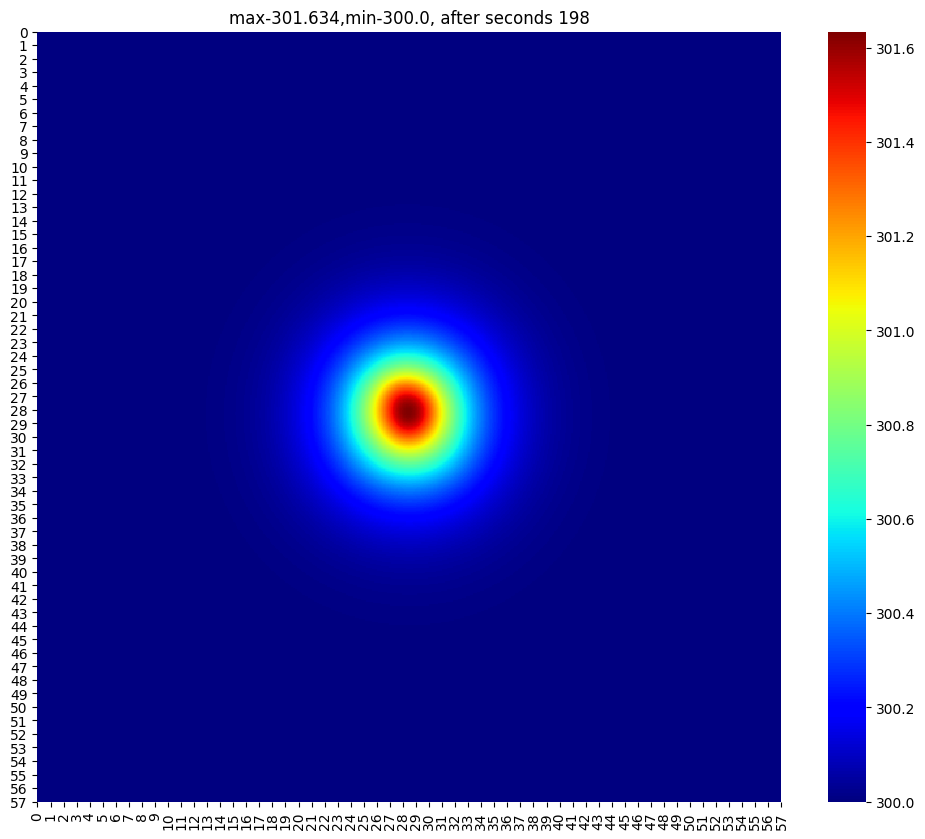

In [ ]:
ax=plt.figure(figsize=(12,10))
u0=titanium 

ax=sns.heatmap(u0[...,-1],cmap="jet",xticklabels =[i for i in range(u0[...,-1].shape[0],3)],yticklabels =[i for i in range(u0[...,-1].shape[1],3)] )
x_ticks = np.linspace(0, u0[...,-1].shape[0], 58,dtype=int)
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.arange(58), rotation=90)

# evenly distribute 58 ticks along y-axis
y_ticks = np.linspace(0, u0[...,-1].shape[1], 58,dtype=int)
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.arange(58),)


plt.title(f"max-{round(u0.max(),3)},min-{round(u0.min(),3)}, after seconds {round(198,2)}")
plt.show()